## Product Review Scrapping & Analysing Tool for Flipkart (Web Scrapping, NLP & Classification)


#### Project Flow 

- Get the Product Name from user. Extract all the reviews available on flipkart.
- Apply NLP tasks on the obtained dataset (Bag of Words Model)
- Apply Classification models to predict whether a review is positve or negative.
- Again apply NLP tasks to obtain the Major highlights/Pros & Major Drawbacks/Cons of the product.
- Create World Cloud for Positive Reviews & Negative Reviews

### Importing Libraries

In [76]:
# Data preprocessing and analysis
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import re
from sklearn.model_selection import train_test_split
import time
import logging

# Web scraping
import urllib.parse
import requests
from bs4 import BeautifulSoup as bs

# Natural Language Processing (NLP)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import ListedColormap

# Suppressing Matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# Set up logging configuration
logging.basicConfig(filename='scrape_log.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [48]:
# Display Full URL
# pd.options.display.max_rows = None  # Display all rows
pd.set_option('display.max_colwidth', None)  # Display full text in columns

### Taking the Input from User (Product Name)

In [49]:
input_by_user = input("Enter the Product name : ")

### Search String generated for the Product Name given

In [50]:
# Search for fulfilled items only
search_query = urllib.parse.quote(input_by_user)
flipkart_url = f"https://www.flipkart.com/search?q={search_query}&p[]=facets.fulfilled_by%255B%255D%3DPlus%2B%2528FAssured%2529"
print(f"Browsing URL: {flipkart_url}")

Browsing URL: https://www.flipkart.com/search?q=iphone&p[]=facets.fulfilled_by%255B%255D%3DPlus%2B%2528FAssured%2529


In [51]:
flipkart_page = requests.get(flipkart_url)
flipkart_page_html = bs(flipkart_page.text, "html.parser")

In [52]:
# Function to extract Product ID from URL
def extract_product_id(url):
    logging.info(f"Extracting Product ID from URL: {url}")
    match = re.search(r'/([a-zA-Z0-9]+)\?', url)
    product_id = match.group(1) if match else None
    logging.info(f"Extracted Product ID: {product_id}")
    return product_id

# Function to generate review page URL

def generate_review_page_url(product_url):
    logging.info(f"Generating review page URL for: {product_url}")

    # Replace "/p/" with "/product-reviews/"
    review_page_url = product_url.replace("/p/", "/product-reviews/")

    # Extract Product ID using regular expression
    match = re.search(r'/([a-zA-Z0-9]+)\?', product_url)
    if match:
        product_id = match.group(1)
        review_page_url = f'{review_page_url}/{product_id}'
        logging.info(f"Generated review page URL: {review_page_url}")
        return review_page_url
    else:
        logging.warning("Failed to extract Product ID from the URL.")
        return None

In [53]:
# Function to scrape product information from a Flipkart search page
def scrape_flipkart(url):
    response = requests.get(url)
    soup = bs(response.text, 'html.parser')

    products = []
    product_elements = soup.find_all('div', class_='_1AtVbE col-12-12')

    for product_element in product_elements:
        product_info = {}

        # Extract relevant information from the product element
        name_element = product_element.find('div', class_='_4rR01T')
        product_info['Name'] = name_element.text.strip(
        ) if name_element else None

        price_element = product_element.find('div', class_='_30jeq3 _1_WHN1')
        product_info['Price'] = price_element.text.strip(
        ) if price_element else None

        discount_element = product_element.find('div', class_='_3Ay6Sb')
        product_info['Discount'] = discount_element.text.strip(
        ) if discount_element else None

        url_element = product_element.find('a', class_='_1fQZEK')
        product_info['URL'] = 'https://www.flipkart.com' + \
            url_element['href'] if url_element and 'href' in url_element.attrs else None

        # Append the product info to the list only if 'Name' is not None
        if product_info['Name'] is not None:
            products.append(product_info)

    return products



In [54]:
# Scrape the data
product_data = scrape_flipkart(flipkart_url)

# Create a DataFrame
df = pd.DataFrame(product_data)


# Assuming 'df' is your DataFrame containing the product information
# df['Product ID'] = df['URL'].apply(extract_product_id)


# Display the DataFrame
display(df.head(2))

,Name,Price,Discount,URL
0,"APPLE iPhone 14 (Blue, 128 GB)","₹57,999",17% off,https://www.flipkart.com/apple-iphone-14-blue-128-gb/p/itmdb77f40da6b6d?pid=MOBGHWFHSV7GUFWA&lid=LSTMOBGHWFHSV7GUFWA3AV8J8&marketplace=FLIPKART&q=iphone&store=tyy%2F4io&spotlightTagId=BestsellerId_tyy%2F4io&srno=s_1_1&otracker=search&fm=organic&iid=856af20d-49da-44e5-a518-6423926ba0be.MOBGHWFHSV7GUFWA.SEARCH&ppt=None&ppn=None&ssid=01yjp8qd0g0000001699554297631&qH=0b3f45b266a97d70
1,"APPLE iPhone 14 (Starlight, 128 GB)","₹58,999",15% off,https://www.flipkart.com/apple-iphone-14-starlight-128-gb/p/itm3485a56f6e676?pid=MOBGHWFHABH3G73H&lid=LSTMOBGHWFHABH3G73HCNASCL&marketplace=FLIPKART&q=iphone&store=tyy%2F4io&spotlightTagId=BestsellerId_tyy%2F4io&srno=s_1_2&otracker=search&fm=organic&iid=856af20d-49da-44e5-a518-6423926ba0be.MOBGHWFHABH3G73H.SEARCH&ppt=None&ppn=None&ssid=01yjp8qd0g0000001699554297631&qH=0b3f45b266a97d70


### Product Info (First Product)

In [55]:
# Assuming 'df' is your DataFrame containing the product information
flipkart_first_product = df.iloc[0]

# Product Name
print(f"Name: {flipkart_first_product['Name']}")
print(f"Discount: {flipkart_first_product['Discount']}")
print(f"Price: {flipkart_first_product['Price']}")

# Generating URL
flipkart_first_product_url = flipkart_first_product['URL']
print(f"Product URL: {flipkart_first_product_url}")

# Generate Review Page URL
product_reviewpage_link = generate_review_page_url(flipkart_first_product_url)
print(f"Product Reviews: {product_reviewpage_link}")

Name: APPLE iPhone 14 (Blue, 128 GB)
Discount: 17% off
Price: ₹57,999
Product URL: https://www.flipkart.com/apple-iphone-14-blue-128-gb/p/itmdb77f40da6b6d?pid=MOBGHWFHSV7GUFWA&lid=LSTMOBGHWFHSV7GUFWA3AV8J8&marketplace=FLIPKART&q=iphone&store=tyy%2F4io&spotlightTagId=BestsellerId_tyy%2F4io&srno=s_1_1&otracker=search&fm=organic&iid=856af20d-49da-44e5-a518-6423926ba0be.MOBGHWFHSV7GUFWA.SEARCH&ppt=None&ppn=None&ssid=01yjp8qd0g0000001699554297631&qH=0b3f45b266a97d70
Product Reviews: https://www.flipkart.com/apple-iphone-14-blue-128-gb/product-reviews/itmdb77f40da6b6d?pid=MOBGHWFHSV7GUFWA&lid=LSTMOBGHWFHSV7GUFWA3AV8J8&marketplace=FLIPKART&q=iphone&store=tyy%2F4io&spotlightTagId=BestsellerId_tyy%2F4io&srno=s_1_1&otracker=search&fm=organic&iid=856af20d-49da-44e5-a518-6423926ba0be.MOBGHWFHSV7GUFWA.SEARCH&ppt=None&ppn=None&ssid=01yjp8qd0g0000001699554297631&qH=0b3f45b266a97d70/itmdb77f40da6b6d


### Custom function for Scrapping the reviews from Flipkart

In [56]:
def review_grabber(review_html_page , data , searchString):
    bigbox = review_html_page.find_all('div',{'class':"_1AtVbE col-12-12"})
    del bigbox[:3]
    #del bigbox[-1]
    for box in bigbox:
        try:
            name = box.div.div.find_all('p', {'class': '_2sc7ZR _2V5EHH'})[0].text
        except:
            name = 'No Name'
        try:
            rating = box.div.div.div.div.div.text
        except:
            rating = 'No Rating'

        try:
            commentHead = box.div.div.div.div.p.text
        except:
            commentHead = 'No Comment Heading'

        try:
            comtag = box.div.div.find_all('div', {'class': ''})
            custComment = comtag[0].div.text
        except:
            custComment = 'No Customer Comment'

        try:
            date = box.div.div.find_all('p', {'class': '_2sc7ZR'})[1].text
        except:
            date = "No Date"

        mydict = {"Product": searchString,
                  "Name": name,
                  "Rating": rating,
                  "CommentHead": commentHead,
                  "Comment": custComment,
                  "Date":date}
        data.append(mydict)

In [57]:
product_name = product_reviewpage_link.split("/")[3]
product_name

'apple-iphone-14-blue-128-gb'

In [58]:
next_link = product_reviewpage_link
response = requests.get(next_link)
review_page_html = bs(response.content,"html.parser")
count_pages = review_page_html.findAll("div",attrs={"class","_2MImiq _1Qnn1K"})
try:
    total_pages = int(count_pages[0].span.text.split(" ")[-1])
except:
    total_pages = 1000
total_pages

808

In [59]:
page = 100

In [60]:
data = []
for i in tqdm(range(1,min(total_pages,page))):
    next_link = product_reviewpage_link + "&page=" +str(i)
    response = requests.get(next_link)
    review_page_html = bs(response.content,"html.parser")
    review_grabber(review_page_html, data , product_name)


  0%|          | 0/99 [00:00<?, ?it/s]

### Reviews scrapped in Pandas Dataframe

In [77]:
df = pd.DataFrame(data)
df.head(20)

,Product,Name,Rating,CommentHead,Comment,Date,New,New_Rating
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago,wow superb camera phone smooth speed lag iphon king alway beauti product,1
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart,1
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help,1
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed,1
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago,thank flipkart trust got devic perfect love best phone segment,1
5,apple-iphone-12-white-128-gb,Flipkart Customer,5,Awesome,"Excellent product worth for every penny, writing this review after using 7 days, earlier was using iPhone 6Plus now on iPhone 12 😍, faster then anything this else.Excellent Picture quality.Just loved it.!!",6 months ago,excel product worth everi penni write review use day earlier use iphon plus iphon faster anyth els excel pictur qualiti love,1
6,apple-iphone-12-white-128-gb,Aman Yadav,5,Brilliant,"It’s my first iPhone ever and I bought it with my earned money through part time jobs in college✌️I am a tech freak so you can trust my views -- A14 Bionic is the fastest, most efficient and reliable processor till date- The camera focuses so quickly that you can take DSLR quality photos.- The screen size 6.1 inches is the most comfortable screen size out there and the OLED retina XDR display is so crisp and everything feels real.- The stereo speakers are so clear even on high volume an...",7 months ago,first iphon ever bought earn money part time job colleg tech freak trust view bionic fastest effici reliabl processor till date camera focus quick take dslr qualiti photo screen size inch comfort screen size ole retina xdr display crisp everyth feel real stereo speaker clear even high volum,1
7,apple-iphone-12-white-128-gb,Pranjal Dwivedi,5,Must buy!,"Delightful phone, the phone is just a peice of art, sleek, eye catchy, super fast and got everything u need...best one available","Mar, 2021",delight phone phone peic art sleek eye catchi super fast got everyth u need best one avail,1
8,apple-iphone-12-white-128-gb,Mohammadhusain Dedhrotiya,5,Brilliant,Excellent product worth every penny right this review after using 7 days earlier was using phone iPhone 6s now on iPhone 12😍😍 faster than anything this else… excellent picture quality just love it iPhone12,4 months ago,excel product worth everi penni right review use day earlier use phone iphon iphon faster anyth els excel pictur qualiti love iphon,1
9,apple-iphone-12-white-128-gb,Indradav Sharma,5,Must buy!,"I really m glad that i went for i phone in place of all other android devices like the Samsung S series nd one plus . Also , m amazed by the 

In [78]:
df.drop_duplicates(inplace=True)

In [79]:
df = df[df["Date"] != "No Date"]
df.reset_index(inplace=True)
df = df.drop(columns="index")
df

,Product,Name,Rating,CommentHead,Comment,Date,New,New_Rating
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago,wow superb camera phone smooth speed lag iphon king alway beauti product,1
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart,1
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help,1
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed,1
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago,thank flipkart trust got devic perfect love best phone segment,1
...,...,...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago,receiv desir,1
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago,camera qualiti,1
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago,buy,1
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago,review usag day batteri disappoint screen time hour batteri ia drain everi night phone idl connect swich manual batteri phone good,0


### Exporting the Dataset

In [80]:
df.to_excel(f"{product_name}.xlsx",index=False)

- Till now we have scrapped all the reviews available for the product on Flikart Website. 
- Now we will be using those reviews as our dataset, apply Bag of Worlds model to generate a Vector of most commonly used words.
- Further ahead we will apply classification algorithms to Predict whether a review is Positive or Negative.

### Importing Scrapped Reviews

In [81]:
data = pd.read_csv("Reviews.csv")
data

,Product,Name,Rating,CommentHead,Comment,Date
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago
...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago


### Cleaning the Reviews (Vectorization, Lemmaniztion)

In [82]:
# Initialize the SnowballStemmer for English
snow_stemmer = SnowballStemmer(language='english')
# Create an empty list to store the preprocessed comments
corpus = []

# Iterate through each comment in the 'Comment' column of the DataFrame
for comment in data['Comment']:
    # Remove non-alphabetic characters and convert to lowercase
    review = re.sub('[^a-zA-Z]', ' ', comment).lower().split()

    # Create a set of English stopwords and remove 'not'
    all_words = set(stopwords.words('english'))
    all_words.remove('not')

    # Stem each word using the SnowballStemmer and exclude stopwords
    review = [snow_stemmer.stem(word)
              for word in review if word not in all_words]

    # Join the stemmed words to form the preprocessed comment and append to the corpus
    corpus.append(' '.join(review))

# Print the preprocessed comments
print(corpus)

# Print the number of preprocessed comments
len(corpus)

['wow superb camera phone smooth speed lag iphon king alway beauti product', 'brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart', 'awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help', 'guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed', 'thank flipkart trust got devic perfect love best phone segment', 'excel product worth everi penni write review use day earlier use iphon plus iphon faster anyth els excel pictur qualiti love', 'first iphon ever bought earn money part time job colleg tech freak trust view bionic fastest effici reliabl processor till date camera focus quick take dslr qualiti photo screen size inch comfort screen size ole retina xdr display crisp everyth feel real stereo speaker clear even high volum', 'delight phone phone peic

5823

- Above is the Reviews after cleaning them.

In [83]:
print(all_words)  ## All stopwords

{"she's", 'they', "needn't", 'ourselves', 'were', 'can', 'aren', "hadn't", 'will', 'am', 'being', 'how', 'as', 'each', 'on', 'ain', 'haven', 'whom', "that'll", 'under', 'some', 'having', 'over', 'didn', 'hadn', 'that', 'she', 'does', 'a', "haven't", 'has', 'be', 'into', 'own', 'do', 'been', 'than', 'against', "shan't", 'him', 'down', 'was', "mustn't", 'where', 'because', 'our', 'out', 'are', 'why', 'through', 'most', 'wasn', 'weren', 'this', "don't", 'who', 'before', 'mightn', 'don', 'of', 'his', 'below', 'me', 'it', 'here', 'myself', "weren't", 'there', 'again', 'couldn', 'further', 'in', 'same', 'm', 'mustn', 'we', 'or', 'i', 'an', 'now', 'no', 'yours', 'shouldn', 'herself', 'after', 'from', 'between', "hasn't", 'her', 'theirs', 'then', 'by', 'nor', 'yourself', 'should', "you'd", "you'll", "you've", 'with', 'just', 'once', 're', "didn't", 'too', 'only', 'these', 'more', 'when', 'and', "shouldn't", 'you', 'have', "you're", 'ma', "should've", 'during', 'both', "won't", "wouldn't", 'but

- Above are the stop words removed from the dataset

In [84]:
data['New'] = corpus
data

,Product,Name,Rating,CommentHead,Comment,Date,New
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago,wow superb camera phone smooth speed lag iphon king alway beauti product
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago,thank flipkart trust got devic perfect love best phone segment
...,...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago,receiv desir
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago,camera qualiti
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago,buy
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago,review usag day batteri disappoint screen time hour batteri ia drain everi night phone idl connect swich manual batteri phone good


In [85]:
new_rating = []

for i in data['Rating']:
    if int(i) > 3:
        new_rating.append(1)
    else:
        new_rating.append(0)

data["New_Rating"] = new_rating
data


,Product,Name,Rating,CommentHead,Comment,Date,New,New_Rating
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago,wow superb camera phone smooth speed lag iphon king alway beauti product,1
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart,1
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help,1
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed,1
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago,thank flipkart trust got devic perfect love best phone segment,1
...,...,...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago,receiv desir,1
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago,camera qualiti,1
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago,buy,1
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago,review usag day batteri disappoint screen time hour batteri ia drain everi night phone idl connect swich manual batteri phone good,0


In [86]:
data['New_Rating'].value_counts()

New_Rating
1    5454
0     369
Name: count, dtype: int64

As we can see that the positive reviews are way more than negatve reviews, so we can make a general perception that the product is good.

## Applying Bag of Words Model 

- Creating Vector of Most used Words in all reviews

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=3000)
x = cv.fit_transform(corpus).toarray()
y = data.iloc[:, -1].values
# Total number of all distinct words in the corpus (all reviews)
print(len(cv.get_feature_names_out()))
# print(x[0])

2930


- The vector generated after applying Bag of words Model has 2930 words in it.

## Applying Classifiction Algorithm
- Applying classification algorithms on Our Vector of Words to predict whether if it is Positive or Negative.

### Splitting the data set into Training and Testing

In [88]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30, random_state = 0)

In [89]:
len(y_train)

4076

In [90]:
x_train.shape

(4076, 2930)

### 1. Logistic Regression Classifier

Logistic Regression Classifier: 


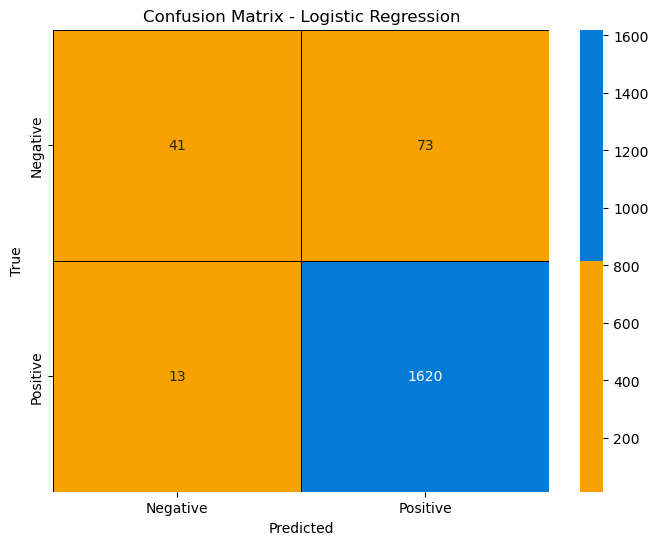

Accuracy Score (Logistic Regression): 0.9507727532913566


In [91]:
# Classifier 1: Logistic Regression
classifier1 = LogisticRegression()
classifier1.fit(x_train, y_train)
y_pred1 = classifier1.predict(x_test)

# Confusion matrix for Logistic Regression
cm1 = confusion_matrix(y_test, y_pred1)
print("Logistic Regression Classifier: ")

# Define custom colormap for Flipkart
flipkart_cmap = ListedColormap(['#f7a200', '#047bd5'])

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

acc1 = accuracy_score(y_test, y_pred1)

# Accuracy score for Logistic Regression
print("Accuracy Score (Logistic Regression):", acc1)

### 2. K-NN Classifier


K-Nearest Neighbors Classifier: 


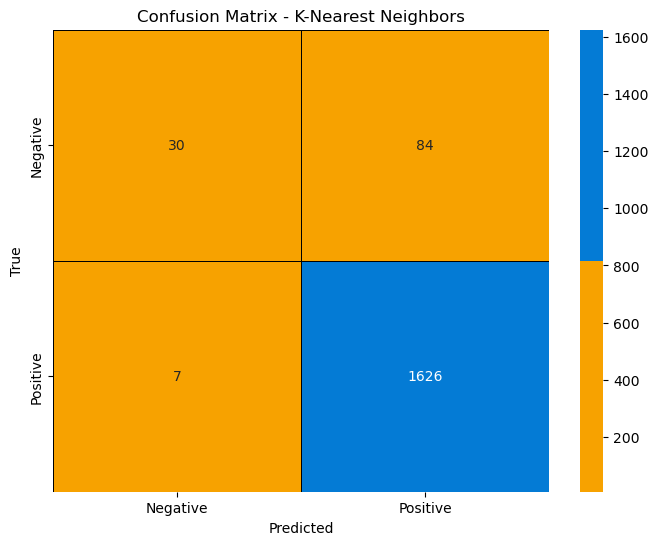

Accuracy Score (K-Nearest Neighbors): 0.9479107040641099


In [92]:
# Classifier 2: K-Nearest Neighbors
classifier2 = KNeighborsClassifier(
    n_neighbors=5, algorithm='auto', metric='manhattan', p=1)
classifier2.fit(x_train, y_train)
y_pred2 = classifier2.predict(x_test)

# Confusion matrix for K-Nearest Neighbors
cm2 = confusion_matrix(y_test, y_pred2)
print("\nK-Nearest Neighbors Classifier: ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()

acc2 = accuracy_score(y_test, y_pred2)
# Accuracy score for K-Nearest Neighbors
print("Accuracy Score (K-Nearest Neighbors):", acc2)

### 3. Kernel SVC 


Support Vector Classifier (RBF Kernel): 


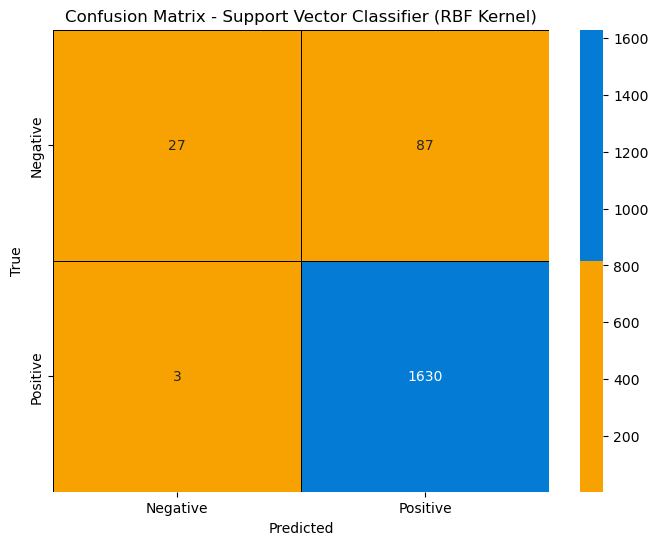

Accuracy Score (SVC - RBF Kernel): 0.9484831139095592


In [93]:
# Classifier 3: Support Vector Classifier with RBF Kernel
classifier3 = SVC(kernel='rbf')
classifier3.fit(x_train, y_train)
y_pred3 = classifier3.predict(x_test)

# Confusion matrix for SVC with RBF Kernel
cm3 = confusion_matrix(y_test, y_pred3)
print("\nSupport Vector Classifier (RBF Kernel): ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Support Vector Classifier (RBF Kernel)')
plt.show()

acc3 = accuracy_score(y_test, y_pred3)
# Accuracy score for SVC with RBF Kernel
print("Accuracy Score (SVC - RBF Kernel):", acc3)

### 4. Gaussian Navie Bayes Classifier


Gaussian Naive Bayes Classifier: 


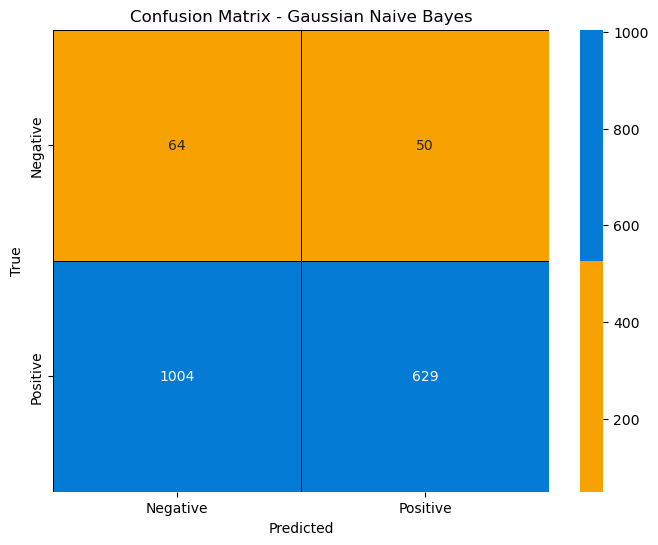

Accuracy Score (Gaussian Naive Bayes): 0.3966800228963938


In [94]:
# Classifier 4: Gaussian Naive Bayes
classifier4 = GaussianNB()
classifier4.fit(x_train, y_train)
y_pred4 = classifier4.predict(x_test)

# Confusion matrix for Gaussian Naive Bayes
cm4 = confusion_matrix(y_test, y_pred4)
print("\nGaussian Naive Bayes Classifier: ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

acc4 = accuracy_score(y_test, y_pred4)

# Accuracy score for Gaussian Naive Bayes
print("Accuracy Score (Gaussian Naive Bayes):", acc4)

### 5. Decision Tree Classifier 


Decision Tree Classifier (Entropy Criterion): 


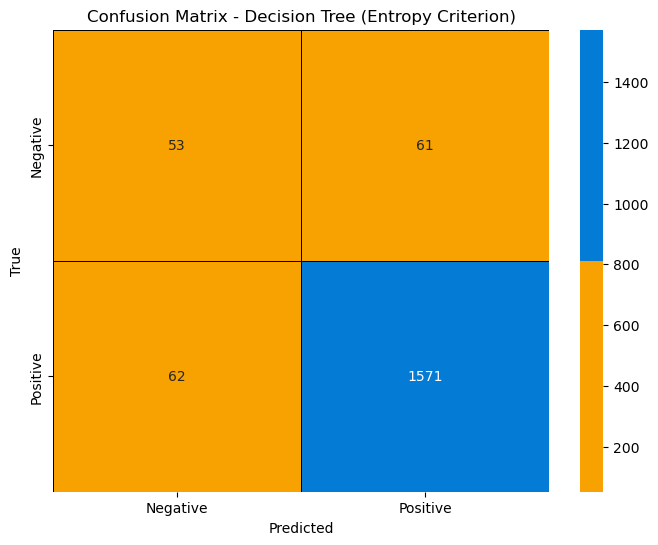

Accuracy Score (Decision Tree - Entropy Criterion): 0.929593589009731


In [95]:
# Classifier 5: Decision Tree with Entropy Criterion
classifier5 = DecisionTreeClassifier(criterion='entropy')
classifier5.fit(x_train, y_train)
y_pred5 = classifier5.predict(x_test)

# Confusion matrix for Decision Tree with Entropy Criterion
cm5 = confusion_matrix(y_test, y_pred5)
print("\nDecision Tree Classifier (Entropy Criterion): ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm5, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree (Entropy Criterion)')
plt.show()

acc5 = accuracy_score(y_test, y_pred5)
# Accuracy score for Decision Tree with Entropy Criterion
print("Accuracy Score (Decision Tree - Entropy Criterion):", acc5)

### 6. Random Forest Classifier


Random Forest Classifier (500 Estimators): 


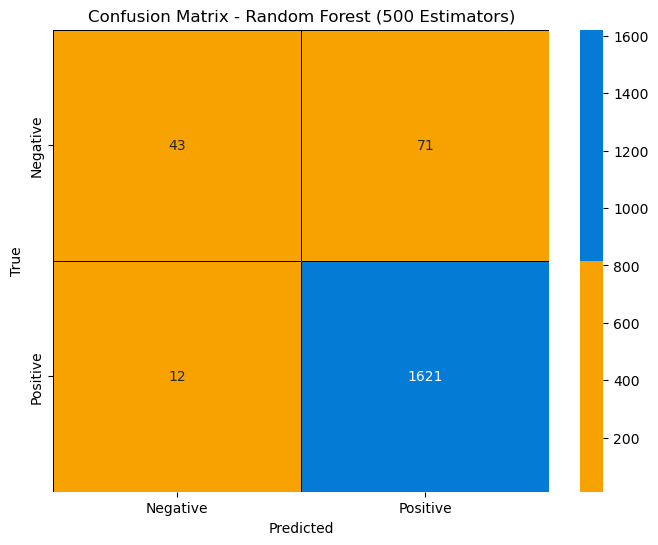

Accuracy Score (Random Forest - 500 Estimators): 0.9524899828277046


In [96]:
# Classifier 6: Random Forest with 500 Estimators
classifier6 = RandomForestClassifier(n_estimators=500, random_state=0)
classifier6.fit(x_train, y_train)
y_pred6 = classifier6.predict(x_test)

# Confusion matrix for Random Forest with 500 Estimators
cm6 = confusion_matrix(y_test, y_pred6)
print("\nRandom Forest Classifier (500 Estimators): ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm6, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (500 Estimators)')
plt.show()

acc6 = accuracy_score(y_test, y_pred6)
# Accuracy score for Random Forest with 500 Estimators
print("Accuracy Score (Random Forest - 500 Estimators):", acc6)

## ANN Classifier


MLP Classifier: 


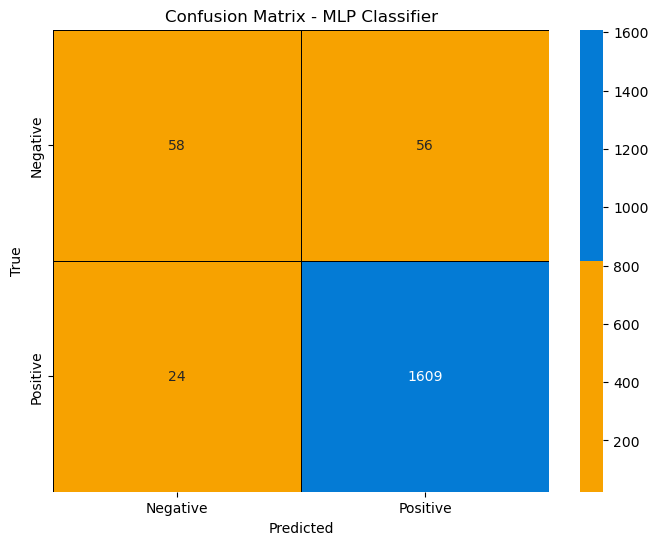

Accuracy Score (MLP Classifier): 0.9542072123640527


In [97]:
# Classifier 7: MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(
    100, 50, 10), activation='relu', solver='adam', max_iter=70, random_state=42)
mlp_classifier.fit(x_train, y_train)
y_pred_mlp = mlp_classifier.predict(x_test)

# Confusion matrix for MLP Classifier
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("\nMLP Classifier: ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MLP Classifier')
plt.show()

# Accuracy score for MLP Classifier
acc7 = accuracy_score(y_test, y_pred_mlp)
print("Accuracy Score (MLP Classifier):", acc7)

## Accuracies of Different Models 

In [98]:
classifiers = [
    "Logistic Regression",
    "K-NN Classifier",
    "Kernel SVC",
    "Naive Bayes Classifier",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "MLP/ANN Classifier"
]

accuracies = [acc1, acc2, acc3, acc4, acc5, acc6, acc7]

max_length = max(len(classifier) for classifier in classifiers)

for classifier, accuracy in zip(classifiers, accuracies):
    formatted_classifier = f"{classifier}:"
    print(f"{formatted_classifier.ljust(max_length + 2)} {round(accuracy * 100, 3)}%")

Logistic Regression:       95.077%
K-NN Classifier:           94.791%
Kernel SVC:                94.848%
Naive Bayes Classifier:    39.668%
Decision Tree Classifier:  92.959%
Random Forest Classifier:  95.249%
MLP/ANN Classifier:        95.421%


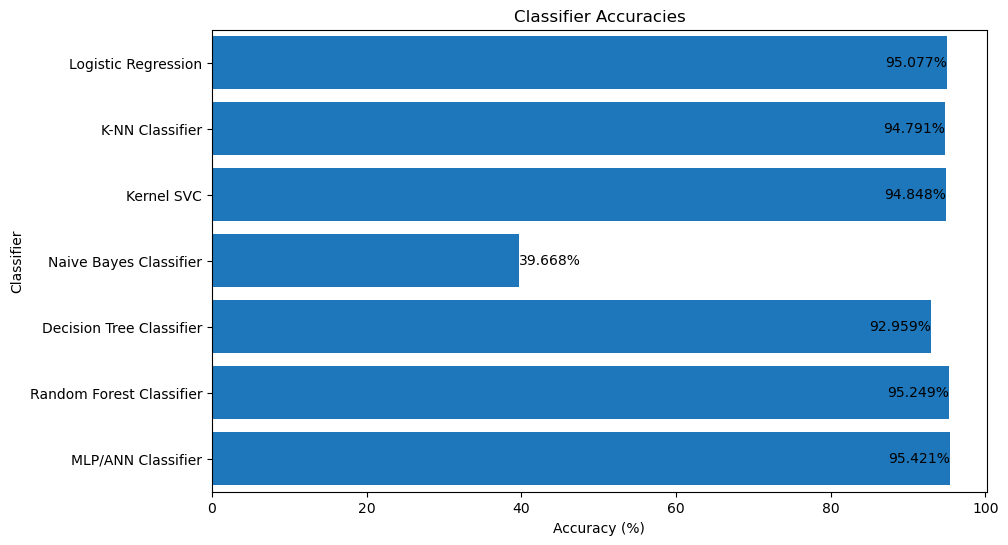

In [99]:
acc_df = pd.DataFrame({'Classifier': classifiers, 'Accuracy': [
                      round(acc * 100, 3) for acc in accuracies]})

# Plotting the bar chart using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Accuracy', y='Classifier', data=acc_df, color='#047bd5')
plt.xlabel('Accuracy (%)')
plt.title('Classifier Accuracies')

# Adding accuracy values inside the bars with dynamic positioning
for index, value in enumerate(accuracies):
    plt.text(value * 100, index, f'{round(value * 100, 3)}%',
             va='center', fontsize=10, ha='left' if value < 0.9 else 'right')

plt.show()

These results suggest strong performance from Logistic Regression, K-NN, Kernel SVC, Decision Tree, Random Forest, and MLP/ANN classifiers, while Naive Bayes trails behind in this specific task.

## Creating World Cloud

In [100]:
def generate_word_cloud(text, title, stopwords=None):
    if stopwords is None:
        stopwords = set(STOPWORDS)

    wordcloud = WordCloud(width=1000, height=1000,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

### Splitting the Reviews into Positive & Negative Subparts

In [101]:
positive_reviews = []
negative_reviews = []

for i in range(len(data)):
    if data['New_Rating'][i] == 1:
      positive_reviews.append(data['New'][i])
    else :
      negative_reviews.append(data['New'][i])

In [102]:
positive_reviews

['wow superb camera phone smooth speed lag iphon king alway beauti product',
 'brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart',
 'awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help',
 'guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed',
 'thank flipkart trust got devic perfect love best phone segment',
 'excel product worth everi penni write review use day earlier use iphon plus iphon faster anyth els excel pictur qualiti love',
 'first iphon ever bought earn money part time job colleg tech freak trust view bionic fastest effici reliabl processor till date camera focus quick take dslr qualiti photo screen size inch comfort screen size ole retina xdr display crisp everyth feel real stereo speaker clear even high volum',
 'delight phone pho

In [103]:
negative_reviews

['overal perform phone good expect appl major overh problem phone minor usag charg even authent w charger phone feel real hot even minor usag especi upper left side left side charg phone get hot not warm like liter hot plug charger minut avoid heat know problem devic general',
 'use oneplus pro year old devic still better batteri backup iphon rest know iphon great camera nice screen io smooth consist mani android phone lack face id pain covid boy give charger suck overal nice phone batteri better',
 'appl fan find iphon light easier use iphon compact size weight display littl better iphon speed also better satisfactori disappoint charger earphon box also price strategi appl product india posit much higher develop countri way round capac pay peopl develop nation like india much lower th',
 'overal good mobil apart call big brand noth special camera gud not wow like samsung ultra current use yes perform realli top class not see lag batteri could better',
 'flipkart support bad',
 'receiv

In [104]:
df = pd.DataFrame(data = positive_reviews, columns = ["Postive_Reviews"] )
df

,Postive_Reviews
0,wow superb camera phone smooth speed lag iphon king alway beauti product
1,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart
2,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help
3,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed
4,thank flipkart trust got devic perfect love best phone segment
...,...
5449,one word great job appl
5450,receiv desir
5451,camera qualiti
5452,buy


### World Cloud for Positive Reviews

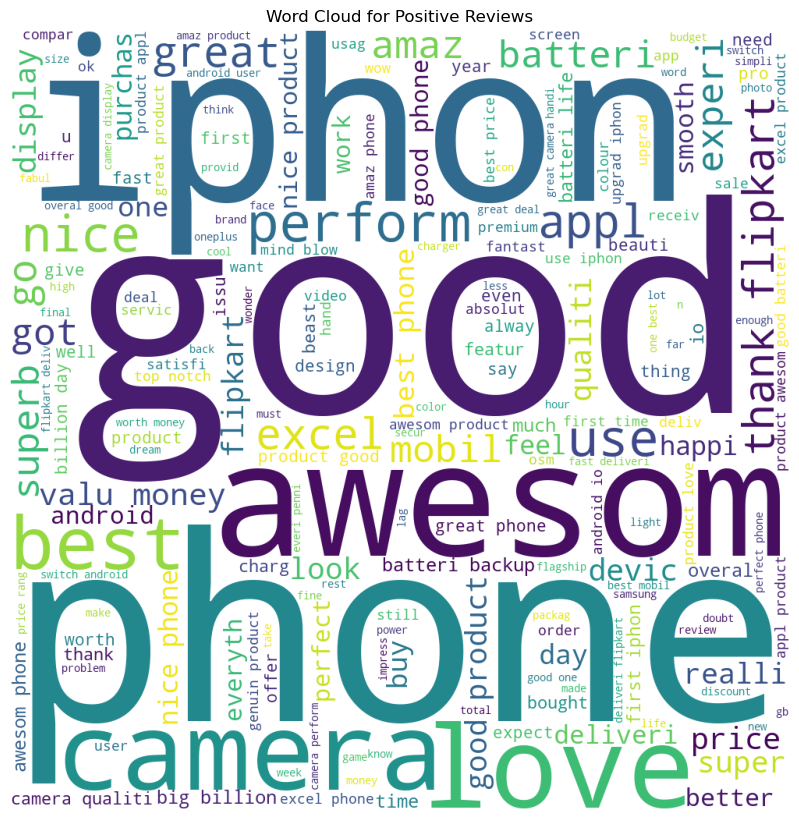

In [105]:
# Combine Positive Reviews for a Word Cloud
positive_comments = ' '.join(str(review) for review in positive_reviews)
generate_word_cloud(positive_comments, 'Word Cloud for Positive Reviews')

### World Cloud for Negative Reviews

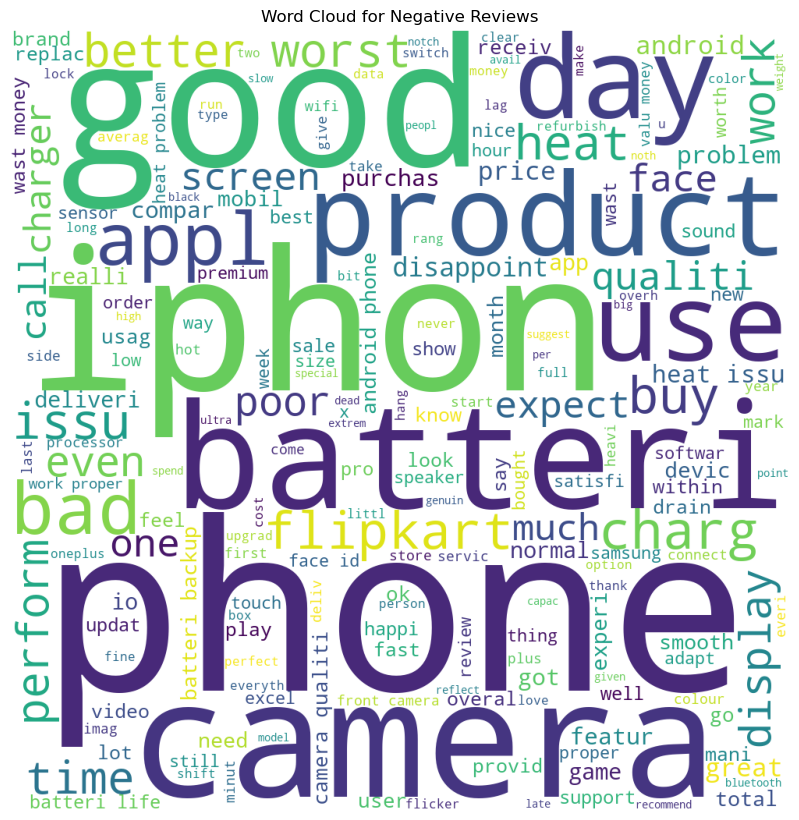

In [106]:
# Combine Negative Reviews for a Word Cloud
negative_comments = ' '.join(str(review) for review in negative_reviews)
generate_word_cloud(negative_comments, 'Word Cloud for Negative Reviews')

### Full Word Cloud

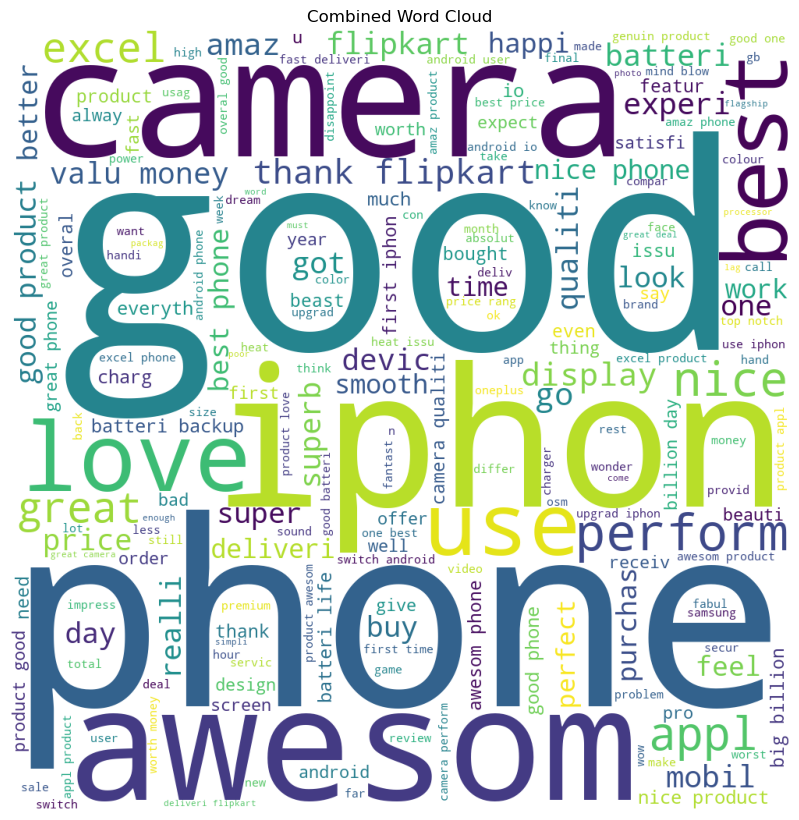

In [107]:
# Combine Positive and Negative Reviews for a Comprehensive Word Cloud
combined_comments = positive_comments + ' ' + negative_comments
generate_word_cloud(combined_comments, 'Combined Word Cloud')

# User prediction

In [151]:
# Function to predict sentiment and provide star rating and emojis
def predict_sentiment_and_rating(user_input):
    # Preprocess the user input
    user_input_processed = [snow_stemmer.stem(word) for word in re.sub(
        '[^a-zA-Z]', ' ', user_input).lower().split() if word not in all_words]
    user_input_processed = ' '.join(user_input_processed)

    # Vectorize the user input using the same CountVectorizer used during training
    user_input_vectorized = cv.transform([user_input_processed]).toarray()

    # Make predictions using the trained MLP Classifier
    user_sentiment_prediction = mlp_classifier.predict(user_input_vectorized)
    user_sentiment_confidence = mlp_classifier.predict_proba(
        user_input_vectorized)

    # Display the user's input
    print("\nUser's Review:")
    print(user_input)

    # Display the sentiment prediction with meaningful labels
    predicted_class_label = "Positive" if user_sentiment_prediction[0] == 1 else "Negative"
    confidence_percentage = max(user_sentiment_confidence[0]) * 100
    print("\nPredicted Sentiment for User Input:", predicted_class_label)
    print(f"Confidence Level: {confidence_percentage:.2f}%")

    # Assign a star rating and emojis based on confidence level
    if predicted_class_label == "Negative":
        if confidence_percentage >= 85:
            star_rating = 1
            emoji_rating = "😞"
        elif confidence_percentage >= 75:
            star_rating = 2
            emoji_rating = "😞😞"
    else:  # Positive
        if confidence_percentage >= 85:
            star_rating = 5
            emoji_rating = "😃😃😃😃😃"
        elif confidence_percentage >= 75:
            star_rating = 4
            emoji_rating = "😃😃😃😃"

    # Add neutral emoji for less than 75% confidence
    if confidence_percentage < 75:
        emoji_rating = "😐"*3

    print(f"\nStar Rating Emoji (out of 5): {emoji_rating}")

In [152]:
# Sample usage with different conditions
user_inputs = [
    # Positive with high confidence (5 stars)
    "I loved the phone",
    "It was a pathetic phone",         # Negative with high confidence (1 star)
    "The phone is okay",               # Neutral (Emoji: 😐)
    "Not bad, but not great either"    # Neutral (Emoji: 😐)
]

for user_input in user_inputs:
    predict_sentiment_and_rating(user_input)
    print("\n" + "="*50 + "\n")


User's Review:
I loved the phone

Predicted Sentiment for User Input: Positive
Confidence Level: 99.81%

Star Rating Emoji (out of 5): 😃😃😃😃😃



User's Review:
It was a pathetic phone

Predicted Sentiment for User Input: Negative
Confidence Level: 99.10%

Star Rating Emoji (out of 5): 😞



User's Review:
The phone is okay

Predicted Sentiment for User Input: Positive
Confidence Level: 92.04%

Star Rating Emoji (out of 5): 😃😃😃😃😃



User's Review:
Not bad, but not great either

Predicted Sentiment for User Input: Positive
Confidence Level: 50.50%

Star Rating Emoji (out of 5): 😐😐😐




### Conclusion

- Just by entering the name of product, We are able to know its Major pro's & cons without actually going through all the reviews on Flipkart
- For any new review, We are also able to predict whether its Positive or Negative
- Both Customers & Company personels can get to know the product's sentiment without much hazzle 